# Scientific Computing: Assignment Set 1
_Boyan Mihaylov (15067602)_

## 0. Imports / Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

Two external Python modules are loaded: one for the DLA model and one for the Gray-Scott reaction-diffusion model.

In [2]:
import dla as dla
import gray_scott as gs

## 1. DLA Based on the Time-Independent Diffusion Equation

In [102]:
reload(dla)

<module 'dla' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 2\\dla.py'>

In [103]:
# Simulation parameters
size = 20

c_grid = dla.run_dla_diff_equation(size, 20, 1.5, 1.0)

Here's what happened: 2 9 -0.001037518409800486 0.002075036819600972
Top neighbour: 0.0
Bottom neighbour: 0.0
Left neighbour: 0.0
Right neighbour: 0.0
Neighbour average: 0.0
Here's what happened: 2 9 -0.0002593796024501215 0.000518759204900243
Top neighbour: 0.0
Bottom neighbour: 0.0
Left neighbour: 0.0
Right neighbour: 0.0
Neighbour average: 0.0
Here's what happened: 2 9 -6.484490061253037e-05 0.00012968980122506074
Top neighbour: 0.0
Bottom neighbour: 0.0
Left neighbour: 0.0
Right neighbour: 0.0
Neighbour average: 0.0
Here's what happened: 2 9 -1.6211225153132593e-05 3.2422450306265186e-05
Top neighbour: 0.0
Bottom neighbour: 0.0
Left neighbour: 0.0
Right neighbour: 0.0
Neighbour average: 0.0
Here's what happened: 2 9 -4.052806288283148e-06 8.105612576566296e-06
Top neighbour: 0.0
Bottom neighbour: 0.0
Left neighbour: 0.0
Right neighbour: 0.0
Neighbour average: 0.0
Here's what happened: 2 9 -1.013201572070787e-06 2.026403144141574e-06
Top neighbour: 0.0
Bottom neighbour: 0.0
Left nei

ValueError: probabilities are not non-negative

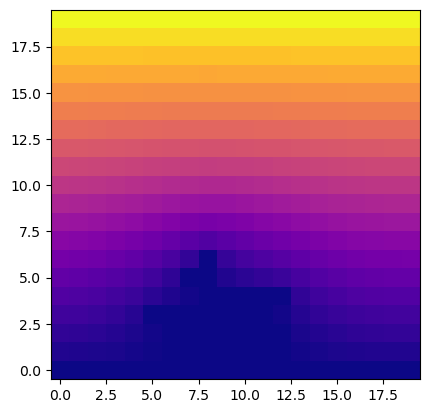

In [91]:
plt.imshow(c_grid, cmap='plasma', origin='lower')